<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install -U sentence-transformers
!pip install flaml

In [2]:
from sentence_transformers import SentenceTransformer
from flaml import AutoML
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import markdown
import lxml
from bs4 import BeautifulSoup
import re
import time
import pickle
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#Imports:

# Clasification model
with open('/content/drive/MyDrive/GHDomains/Resources/automl.pkl', 'rb') as fp:
  automl = pickle.load(fp)
# Label encoder
with open('/content/drive/MyDrive/GHDomains/Resources/label_encoder.pkl', 'rb') as fp:
  le = pickle.load(fp)
# Num scaler
with open('/content/drive/MyDrive/GHDomains/Resources/num_scaler.pkl', 'rb') as fp:
  scaler = pickle.load(fp)
# Column names
with open('/content/drive/MyDrive/GHDomains/Resources/column_names.pkl', 'rb') as fp:
  column_names = pickle.load(fp)

In [4]:
new_popular_df = pd.read_csv('/content/drive/MyDrive/GHDomains/New_popular_download/all_repos.csv')
new_popular_df = new_popular_df.rename(columns={"README": "Readme"}) 
new_popular_df

Name  \
0                     vuejs/devtools   
1    futurice/android-best-practices   
2    microsoft/Web-Dev-For-Beginners   
3             airbnb/react-sketchapp   
4               eugeneyan/applied-ml   
..                               ...   
888               graphql/dataloader   
889                 junyanz/CycleGAN   
890                     Tencent/wcdb   
891          halfrost/Halfrost-Field   
892                 hackjutsu/Lepton   

                                           Description  \
0    ‚öôÔ∏è Browser devtools extension for debugging Vu...   
1    Do's and Don'ts for Android development, by Fu...   
2    24 Lessons, 12 Weeks, Get Started as a Web Dev...   
3                render React components to Sketch ‚öõÔ∏èüíé   
4    üìö Papers & tech blogs by companies sharing the...   
..                                                 ...   
888  DataLoader is a generic utility to be used as ...   
889  Software that can generate photos from paintin...   
890  WCDB is a cross-platform database framework de...   
891                ‚úçüèª ËøôÈáåÊòØÂÜôÂçöÂÆ¢ÁöÑÂú∞Êñπ ‚Äî‚Äî Halfrost-Field ÂÜ∞Èúú‰πãÂú∞   
892  üíª     Democratizing Snippet Management (macOS/...   

                                                Readme  \
0    # vue-devtools\n\n![screenshot](./media/screen...   
1    # Best practices in Android development\n\nAvo...   
2    [![GitHub license](https://img.shields.io/gith...   
3    <div align="center">\n  <img alt="react-sketch...   
4    # applied-ml\nCurated papers, articles, and bl...   
..                                                 ...   
888  # DataLoader\n\nDataLoader is a generic utilit...   
889  <img src='imgs/horse2zebra.gif' align="right" ...   
890  # WCDB\n\n[![PRs Welcome](https://img.shields....   
891  # Halfrost-Field ÂÜ∞Èúú‰πãÂú∞\n\n<p align='center'>\n<...   
892  > **To Lepton users around the world in more t...   

                                                Labels  \
0    ['accepted proposition', 'bug', 'cannot reprod...   
1    ['2018', 'answered', 'bug', 'discussion', 'dup...   
2    ['bug', 'dependencies', 'documentation', 'dupl...   
3    ['awaiting-review', 'bug', 'chore', 'discuss',...   
4    ['bug', 'documentation', 'duplicate', 'enhance...   
..                                                 ...   
888  ['bug', 'dependencies', 'duplicate', 'enhancem...   
889  ['bug', 'duplicate', 'enhancement', 'help want...   
890  ['bug', 'duplicate', 'enhancement', 'help want...   
891  ['bug', 'duplicate', 'enhancement', 'help want...   
892  ['3rd party', 'bug', 'CI', 'dev', 'discussion'...   

                                          Contributors  \
0    ['Akryum', 'yyx990803', 'posva', 'bartlomieju'...   
1    ['staltz', 'peter-tackage', 'minsoopark', 'and...   
2    ['jlooper', 'ManuSquall', 'San1ay', 'silversky...   
3    ['jongold', 'mathieudutour', 'macintoshhelper'...   
4    ['eugeneyan', 'shreyansh26', 'chmnsk', 'nilesh...   
..                                                 ...   
888  ['leebyron', 'wincent', 'gajus', 'brianwarner'...   
889  ['junyanz', 'taesungp', 'aferriss', 'asturur',...   
890  ['RingoD', 'John-He-928', 'infinnie', 'drakeet...   
891                  ['halfrost', 'somnus-L', 'devSC']   
892  ['hackjutsu', 'allcontributors[bot]', 'DNLHC',...   

                                             Languages  \
0    ['TypeScript', 'Vue', 'JavaScript', 'HTML', 'S...   
1                                                  NaN   
2                 ['JavaScript', 'HTML', 'CSS', 'Vue']   
3                         ['TypeScript', 'JavaScript']   
4                                                  NaN   
..                                                 ...   
888                            ['JavaScript', 'Shell']   
889                  ['Lua', 'Python', 'Shell', 'TeX']   
890  ['C', 'C++', 'Java', 'Swift', 'Objective-C++',...   
891  ['Go', 'CSS', 'Jupyter Notebook', 'Objective-C...   
892                     ['JavaScript', 'SCSS', 'HTML']   

      

In [5]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [67]:
def join_words_from_lists(text, join=False):
  text = str(text)
  if text == 'nan':
    return ''
  else:
    text = text[1:-1]
    text = text.replace('\'','')
    text = text.split(',')
    if join:
      text = ' '.join([word.strip() for word in text])
    return text

def clean_htmltags(text):

    text = markdown.markdown(text)                                # convert the code to html
    text = BeautifulSoup(text, "lxml")
    text = text.get_text()                                        # html.parser #XML stands for "eXtensible Markup Language",

    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)                    # delete remaining tags
    text = re.sub('\s{2,}', " ", text)                            # regularise whitespaces
                                    
    return text

def vectorize_categorical(df_Serie, prefix):
    lp_index = df_Serie.index

    vect = CountVectorizer(tokenizer=join_words_from_lists)
    lp_Serie = vect.fit_transform(df_Serie.astype(str))

    lp_Serie = pd.DataFrame(lp_Serie.toarray(), columns=vect.get_feature_names_out(), index=lp_index).add_prefix(prefix)
    lp_Serie = lp_Serie.astype(pd.SparseDtype(np.int64))
    return lp_Serie

In [87]:
def fit_transform(df, selected_features):

  # Apply text pre-processing
  df['Labels'] = df['Labels'].apply(lambda x: join_words_from_lists(x, join=True))
  df['Readme'] = df['Readme'].astype(str)
  df['Readme'].apply(lambda x: clean_htmltags(x))
  df['Description'] = df['Description'].astype(str)
  df['Description'] = df['Description'].replace('nan','')
  df['Text_data']   = df['Description'] + df['Readme'] + df['Labels']
  transformed_df = model.encode(df['Text_data'].to_list())

  # Vectorise categorical features
  cn_vect = vectorize_categorical(df['Contributors'], 'cn: ')
  pl_vect = vectorize_categorical(df['Languages'], 'pl: ')
  tp_vect = vectorize_categorical(df['Topics'], 'tp: ')
  ct_vect = vectorize_categorical(df['Contents'], 'ct: ')
  li_vect = vectorize_categorical(df['Licence'], 'li: ')

  # transform numbers of stars, forks y releases
  num_vectors = df[['Stars','Forks', 'Releases']].astype(np.float64)
  num_columns = num_vectors.columns
  num_index = num_vectors.index
  num_vectors = scaler.transform(num_vectors)
  num_vectors = pd.DataFrame(num_vectors, columns=num_columns, index=num_index)

  # Concat the dataframe and filter the columns to plug into the model
  transformed_df = pd.DataFrame(transformed_df, index=df.index).add_prefix('Text ')
  transformed_df = pd.concat([transformed_df, cn_vect, pl_vect, tp_vect, ct_vect, li_vect, num_vectors], axis=1)
  transformed_df = transformed_df.reindex(columns=column_names, fill_value=0)

  return transformed_df

In [ ]:
transformed_df = fit_transform(df=new_popular_df, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())

In [ ]:
le.inverse_transform(prediction)

In [ ]:
new_popular_df['Predicted_labels'] = le.inverse_transform(prediction)
new_popular_df

Name  \
0                     vuejs/devtools   
1    futurice/android-best-practices   
2    microsoft/Web-Dev-For-Beginners   
3             airbnb/react-sketchapp   
4               eugeneyan/applied-ml   
..                               ...   
888               graphql/dataloader   
889                 junyanz/CycleGAN   
890                     Tencent/wcdb   
891          halfrost/Halfrost-Field   
892                 hackjutsu/Lepton   

                                           Description  \
0    ‚öôÔ∏è Browser devtools extension for debugging Vu...   
1    Do's and Don'ts for Android development, by Fu...   
2    24 Lessons, 12 Weeks, Get Started as a Web Dev...   
3                render React components to Sketch ‚öõÔ∏èüíé   
4    üìö Papers & tech blogs by companies sharing the...   
..                                                 ...   
888  DataLoader is a generic utility to be used as ...   
889  Software that can generate photos from paintin...   
890  WCDB is a cross-platform database framework de...   
891                ‚úçüèª ËøôÈáåÊòØÂÜôÂçöÂÆ¢ÁöÑÂú∞Êñπ ‚Äî‚Äî Halfrost-Field ÂÜ∞Èúú‰πãÂú∞   
892  üíª     Democratizing Snippet Management (macOS/...   

                                                Readme  \
0    vue-devtools Documentation Install the extensi...   
1    Best practices in Android development Avoid re...   
2     Web Development for Beginners - A Curriculum ...   
3     render React components to Sketch; tailor-mad...   
4    applied-ml Curated papers, articles, and blogs...   
..                                                 ...   
888  DataLoader DataLoader is a generic utility to ...   
889   CycleGAN PyTorch project page paper Torch imp...   
890  WCDB ‰∏≠ÊñáÁâàÊú¨ËØ∑ÂèÇÁúãËøôÈáå WCDB is an efficient, complete,...   
891  Halfrost-Field ÂÜ∞Èúú‰πãÂú∞ ‚≠êÔ∏è ‰∏∫‰ªÄ‰πàË¶ÅÂª∫Ëøô‰∏™‰ªìÂ∫ì ‰∏ñ‰∫∫ÈÉΩËØ¥ÈòÖËØªÂºÄÊ∫êÊ°ÜÊû∂ÁöÑÊ∫ê‰ª£...   
892   To Lepton users around the world in more than...   

                                                Labels  \
0    accepted proposition bug cannot reproduce cont...   
1    2018 answered bug discussion duplicate enhance...   
2    bug dependencies documentation duplicate enhan...   
3    awaiting-review bug chore discuss docs duplica...   
4    bug documentation duplicate enhancement good f...   
..                                                 ...   
888  bug dependencies duplicate enhancement help wa...   
889  bug duplicate enhancement help wanted invalid ...   
890  bug duplicate enhancement help wanted invalid ...   
891  bug duplicate enhancement help wanted invalid ...   
892  3rd party bug CI dev discussion duplicate enha...   

                                          Contributors  \
0    ['Akryum', 'yyx990803', 'posva', 'bartlomieju'...   
1    ['staltz', 'peter-tackage', 'minsoopark', 'and...   
2    ['jlooper', 'ManuSquall', 'San1ay', 'silversky...   
3    ['jongold', 'mathieudutour', 'macintoshhelper'...   
4    ['eugeneyan', 'shreyansh26', 'chmnsk', 'nilesh...   
..                                                 ...   
888  ['leebyron', 'wincent', 'gajus', 'brianwarner'...   
889  ['junyanz', 'taesungp', 'aferriss', 'asturur',...   
890  ['RingoD', 'John-He-928', 'infinnie', 'drakeet...   
891                  ['halfrost', 'somnus-L', 'devSC']   
892  ['hackjutsu', 'allcontributors[bot]', 'DNLHC',...   

                                             Languages  \
0    ['TypeScript', 'Vue', 'JavaScript', 'HTML', 'S...   
1                                                  NaN   
2                 ['JavaScript', 'HTML', 'CSS', 'Vue']   
3                         ['TypeScript', 'JavaScript']   
4                                                  NaN   
..                                                 ...   
888                            ['JavaScript', 'Shell']   
889                  ['Lua', 'Python', 'Shell', 'TeX']   
890  ['C', 'C++', 'Java', 'Swift', 'Objective-C++',...   
891  ['Go', 'CSS', 'Jupyter Notebook', 'Objective-C...   

In [ ]:
new_popular_df.to_csv('/content/drive/MyDrive/GHDomains/Resources/new_popular_df_predicted.csv', index=False)

In [8]:
less_popular_df = pd.read_csv('/content/drive/MyDrive/GHDomains/Resources/less_popular_df_predicted.csv')
less_popular_df = less_popular_df.rename(columns={"README": "Readme"}) 
less_popular_df

Name  \
0                            yetanother-blog/indiepen   
1                           SnowdogApps/magento2-menu   
2                                   api-platform/demo   
3                   open-telemetry/opentelemetry-ruby   
4                      rroemhild/docker-test-openldap   
5                                    ikostrikov/jaxrl   
6                       balena-io-library/base-images   
7                      BitBagCommerce/SyliusCmsPlugin   
8   GPUOpen-LibrariesAndSDKs/RadeonProRenderBlende...   
9                         ObsidianLabs/EthereumStudio   
10                         quantumblacklabs/kedro-viz   
11                                  horsicq/XPEViewer   
12                                    Renanse/Ardor3D   
13                kubernetes-csi/external-provisioner   
14                                      mlochbaum/BQN   
15                            Bunlong/react-papaparse   
16                       google/cloud-forensics-utils   
17                           phoenixframework/esbuild   
18                      prescottprue/cypress-firebase   
19              openshift/cluster-monitoring-operator   
20                     KnisterPeter/vscode-commitizen   
21                                    UniTime/unitime   
22                                  yankailab/OpenKAI   
23                                       gql-dart/gql   
24                               codesandbox/sandpack   
25                        kahne/NonAutoregGenProgress   
26                             Skyost/FlutterWeekView   
27                                         azist/azos   
28                                      fb55/css-what   
29                                     jwcpp/jwEngine   
30                            janraasch/hugo-bearblog   
31                  kubecost/cost-analyzer-helm-chart   
32                        sensedeep/dynamodb-onetable   
33          jaegeral/companies-hiring-security-remote   
34                               staticbackendhq/core   
35                            TypeNetwork/Roboto-Flex   
36                            DataDog/dd-trace-dotnet   
37                                   ornladios/ADIOS2   
38                              alimranahmed/LaraBlog   
39                                      pikelang/Pike   
40                                         kor-ui/kor   
41                        wildfish/django-gdpr-assist   
42            bancolombia/scaffold-clean-architecture   
43                      jenkinsci/http-request-plugin   
44                    jeremyHixon/RationalOptionPages   
45                   thesolarnomad/lora-serialization   
46                                  wallix/redemption   
47                                  bcb/jsonrpcserver   
48                                   openstack/manila   
49                            eslint/generator-eslint   

                                          Description  \
0   An independent and privacy-friendly solution t...   
1   Provides powerful menu editor to replace categ...   
2             Demo app for the API Platform framework   
3      OpenTelemetry Ruby API & SDK, and related gems   
4   Docker OpenLDAP Server for testing LDAP applic...   
5   JAX (Flax) implementation of algorithms for De...   
6                                                 NaN   
7   Content management system for eCommerce apps c...   
8                                                 NaN   
9   Ethereum Studio is a cross-platform graphic ID...   
10  Visualise your Kedro data and machine-learning...   
11  PE file viewer/editor for Windows, Linux and M...   
12  Ardor3D is a free Java based, professionally o...   
13  Sidecar container that watches Kubernetes Pers...   
14     An APL-like programming language. Self-hosted!   
15  react-papaparse is the fastest in-browser CSV ...   
16  Python library to carry out DFIR analysis on t...   
17                           An installer for esbuild   
18  Cypress plugin and custom commands for testing...   
1

In [88]:
transformed_df = fit_transform(df=less_popular_df, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())
le.inverse_transform(prediction)

array(['Web libraries and frameworks', 'Web libraries and frameworks',
       'Web libraries and frameworks', 'Non-web libraries and frameworks',
       'Software tools', 'Non-web libraries and frameworks',
       'Documentation', 'Application & System software',
       'Non-web libraries and frameworks', 'Software tools',
       'Software tools', 'Software tools',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Software tools', 'Software tools', 'Software tools',
       'Software tools', 'Software tools',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Application & System software',
       'Non-web libraries and frameworks',
       'Non-web libraries and framewo

In [89]:
less_popular_df['Predicted_labels'] = le.inverse_transform(prediction)
less_popular_df

Name  \
0                            yetanother-blog/indiepen   
1                           SnowdogApps/magento2-menu   
2                                   api-platform/demo   
3                   open-telemetry/opentelemetry-ruby   
4                      rroemhild/docker-test-openldap   
5                                    ikostrikov/jaxrl   
6                       balena-io-library/base-images   
7                      BitBagCommerce/SyliusCmsPlugin   
8   GPUOpen-LibrariesAndSDKs/RadeonProRenderBlende...   
9                         ObsidianLabs/EthereumStudio   
10                         quantumblacklabs/kedro-viz   
11                                  horsicq/XPEViewer   
12                                    Renanse/Ardor3D   
13                kubernetes-csi/external-provisioner   
14                                      mlochbaum/BQN   
15                            Bunlong/react-papaparse   
16                       google/cloud-forensics-utils   
17                           phoenixframework/esbuild   
18                      prescottprue/cypress-firebase   
19              openshift/cluster-monitoring-operator   
20                     KnisterPeter/vscode-commitizen   
21                                    UniTime/unitime   
22                                  yankailab/OpenKAI   
23                                       gql-dart/gql   
24                               codesandbox/sandpack   
25                        kahne/NonAutoregGenProgress   
26                             Skyost/FlutterWeekView   
27                                         azist/azos   
28                                      fb55/css-what   
29                                     jwcpp/jwEngine   
30                            janraasch/hugo-bearblog   
31                  kubecost/cost-analyzer-helm-chart   
32                        sensedeep/dynamodb-onetable   
33          jaegeral/companies-hiring-security-remote   
34                               staticbackendhq/core   
35                            TypeNetwork/Roboto-Flex   
36                            DataDog/dd-trace-dotnet   
37                                   ornladios/ADIOS2   
38                              alimranahmed/LaraBlog   
39                                      pikelang/Pike   
40                                         kor-ui/kor   
41                        wildfish/django-gdpr-assist   
42            bancolombia/scaffold-clean-architecture   
43                      jenkinsci/http-request-plugin   
44                    jeremyHixon/RationalOptionPages   
45                   thesolarnomad/lora-serialization   
46                                  wallix/redemption   
47                                  bcb/jsonrpcserver   
48                                   openstack/manila   
49                            eslint/generator-eslint   

                                          Description  \
0   An independent and privacy-friendly solution t...   
1   Provides powerful menu editor to replace categ...   
2             Demo app for the API Platform framework   
3      OpenTelemetry Ruby API & SDK, and related gems   
4   Docker OpenLDAP Server for testing LDAP applic...   
5   JAX (Flax) implementation of algorithms for De...   
6                                                       
7   Content management system for eCommerce apps c...   
8                                                       
9   Ethereum Studio is a cross-platform graphic ID...   
10  Visualise your Kedro data and machine-learning...   
11  PE file viewer/editor for Windows, Linux and M...   
12  Ardor3D is a free Java based, professionally o...   
13  Sidecar container that watches Kubernetes Pers...   
14     An APL-like programming language. Self-hosted!   
15  react-papaparse is the fastest in-browser CSV ...   
16  Python library to carry out DFIR analysis on t...   
17                           An installer for esbuild   
18  Cypress plugin and custom commands for testing...   
1

In [90]:
print(classification_report(less_popular_df['True_label'], less_popular_df['Predicted_labels'], target_names=le.classes_))

                                  precision    recall  f1-score   support

   Application & System software       0.40      0.17      0.24        12
                   Documentation       0.25      0.50      0.33         2
Non-web libraries and frameworks       0.50      0.75      0.60        12
                  Software tools       0.71      0.77      0.74        13
    Web libraries and frameworks       0.67      0.55      0.60        11

                        accuracy                           0.56        50
                       macro avg       0.51      0.55      0.50        50
                    weighted avg       0.56      0.56      0.54        50



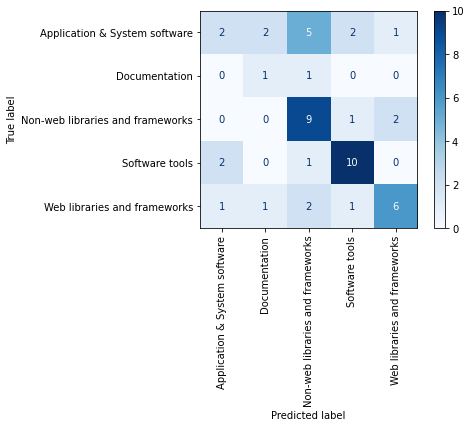

In [91]:
cnf_matrix = confusion_matrix(less_popular_df['True_label'], less_popular_df['Predicted_labels'])
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=le.classes_).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

In [ ]:
less_popular_df.to_csv('/content/drive/MyDrive/GHDomains/Resources/less_popular_df_predicted.csv', index=False)

In [92]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/drive/MyDrive/GHDomains/expanded_frame_final.csv')
df.dropna(subset=['Readme'], inplace=True)
df.drop(31, axis=0, inplace=True)   #removed repo Homebrew/legacy-homebrew      # Software tools
df.drop(124, axis=0, inplace=True)  #removed repo shadowsocks/shadowsocks       # Software tools
df.drop(237, axis=0, inplace=True)  #removed repo npm/npm                       # Software tools
df.drop(3057, axis=0, inplace=True) #removed repo firstopinion/formatter.js     # Web libraries and frameworks
df.drop(4488, axis=0, inplace=True) #removed repo jersey/jersey                 # Web libraries and frameworks
df.reset_index(inplace=True, drop=True)

df['Domain'] = df['Domain'].replace(['System software','Application software'], 'Application & System software')
df
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!='Domain'], df['Domain'], test_size=0.1, random_state=42, stratify=df['Domain'])

In [93]:
transformed_df = fit_transform(df=X_test, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())
le.inverse_transform(prediction)

array(['Application & System software',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Documentation', 'Web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Web libraries and frameworks', 'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Application & System software',
       'Non-web libraries and frameworks', 'Software tools',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Non-web libraries and frameworks', 'Documentation',
       'Web libraries and frameworks', 'Software tools',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Software tools', 'Web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web li

In [96]:
X_test['Predicted_labels'] = le.inverse_transform(prediction)
print(classification_report(y_test, X_test['Predicted_labels'], target_names=le.classes_))

                                  precision    recall  f1-score   support

   Application & System software       0.64      0.52      0.58        61
                   Documentation       0.79      0.72      0.76        43
Non-web libraries and frameworks       0.74      0.73      0.74       143
                  Software tools       0.67      0.60      0.64        96
    Web libraries and frameworks       0.72      0.85      0.78       152

                        accuracy                           0.72       495
                       macro avg       0.71      0.69      0.70       495
                    weighted avg       0.71      0.72      0.71       495



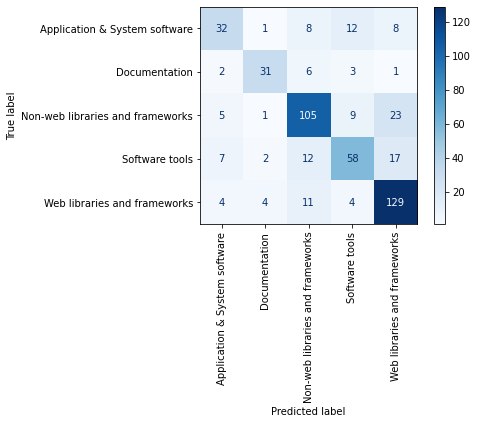

In [97]:
cnf_matrix = confusion_matrix(y_test, X_test['Predicted_labels'])
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=le.classes_).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')